In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [2]:
n_range = range(616, 616+200)
N = len(n_range)
SXM_PATH = ["electromigration_29/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 11
detect_kwargs = {
    'minmass' : 2,
    'maxsize' : 4,
    'separation' : 5,
}
f = tp.batch(frames[:], molecule_size, **detect_kwargs)

Frame 199: 5 features


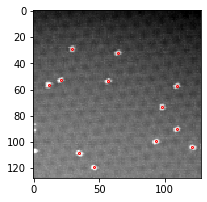

(-0.5, 127.5, 127.5, -0.5)

In [3]:
fig=plt.figure(figsize=(3, 5))
idx = 12
ax = tp.annotate(f[f['frame']==idx], frames[idx], plot_style={'markersize':1})
ax.axis('off')

Frame 199: 5 trajectories present.


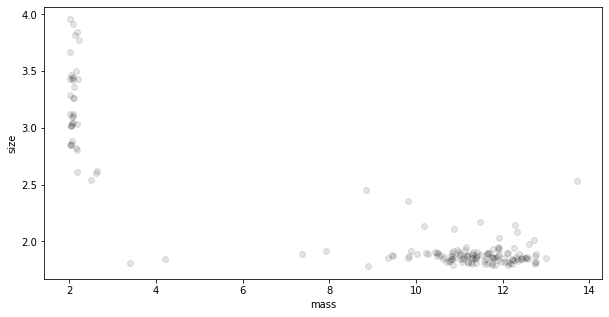

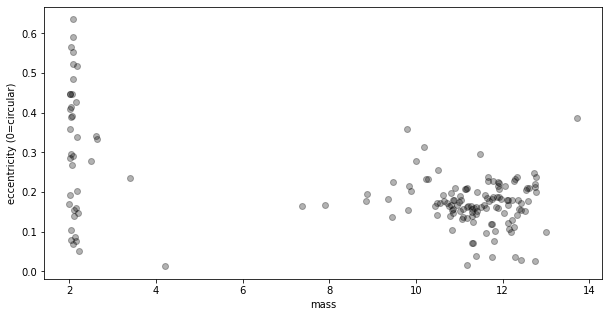

In [4]:
search_kws = {
    'search_range' : 30,
    'adaptive_stop' : 2.0,
    'adaptive_step' : 0.95,
}
t = tp.link(f, **search_kws)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [5]:
min_mass, max_mass = 9, 14
min_size, max_size = 1.8, 2.2
min_ecc, max_ecc = 0.05, 0.3
t1 = t[t['ecc'].between(min_ecc, max_ecc) &
       t['size'].between(min_size, max_size) & 
       t['mass'].between(min_mass, max_mass)]
t2 = tp.filter_stubs(t, 30) # require 30 steps
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 162
After: 13


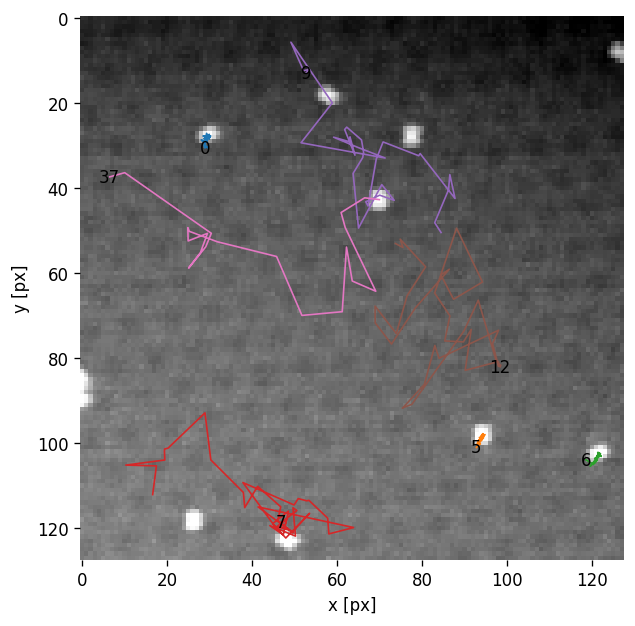

In [6]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig=plt.figure(figsize=(8, 6), dpi=120)
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
# plt.axis('off')
ln, = ax1.plot([], [], lw=3)
ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
def animate(i):
    plt.cla()
    tp.plot_traj(t2[(t2['frame']<=i)], superimpose=frames[i], label=True, ax=ax1)
    ax1.set_prop_cycle(color=['g', 'r', 'c', 'm', 'y', 'k'])
# Set up formatting for the movie files
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
line_ani = matplotlib.animation.FuncAnimation(fig, animate, frames=50)
line_ani

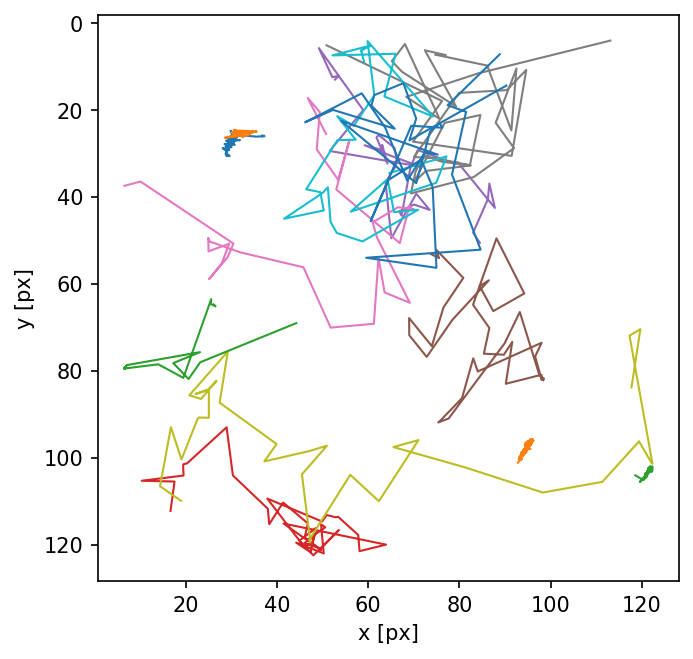

<AxesSubplot:xlabel='x [px]', ylabel='y [px]'>

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
tp.plot_traj(t2)

# MSD

In [8]:
d = tp.compute_drift(t2)
tm = tp.subtract_drift(t2.copy(), d)
tm.head(3)

y           x      mass      size       ecc    signal  \
frame                                                                   
0       30.512413   28.906653  3.840074  1.902541  0.187534  0.274563   
0      101.076221   92.833409  4.177558  1.833060  0.229739  0.308884   
0      103.971480  118.598930  5.348265  3.138798  0.628408  0.276470   

        raw_mass        ep  frame  particle  
frame                                        
0     -13.115367 -0.017731      0         0  
0      49.550714 -0.230571      0         5  
0      53.911004 -1.399188      0         6

/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
/home/a/as/asai/dsgo/trading/trading/lib/python3.7/site-packages/trackpy/motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


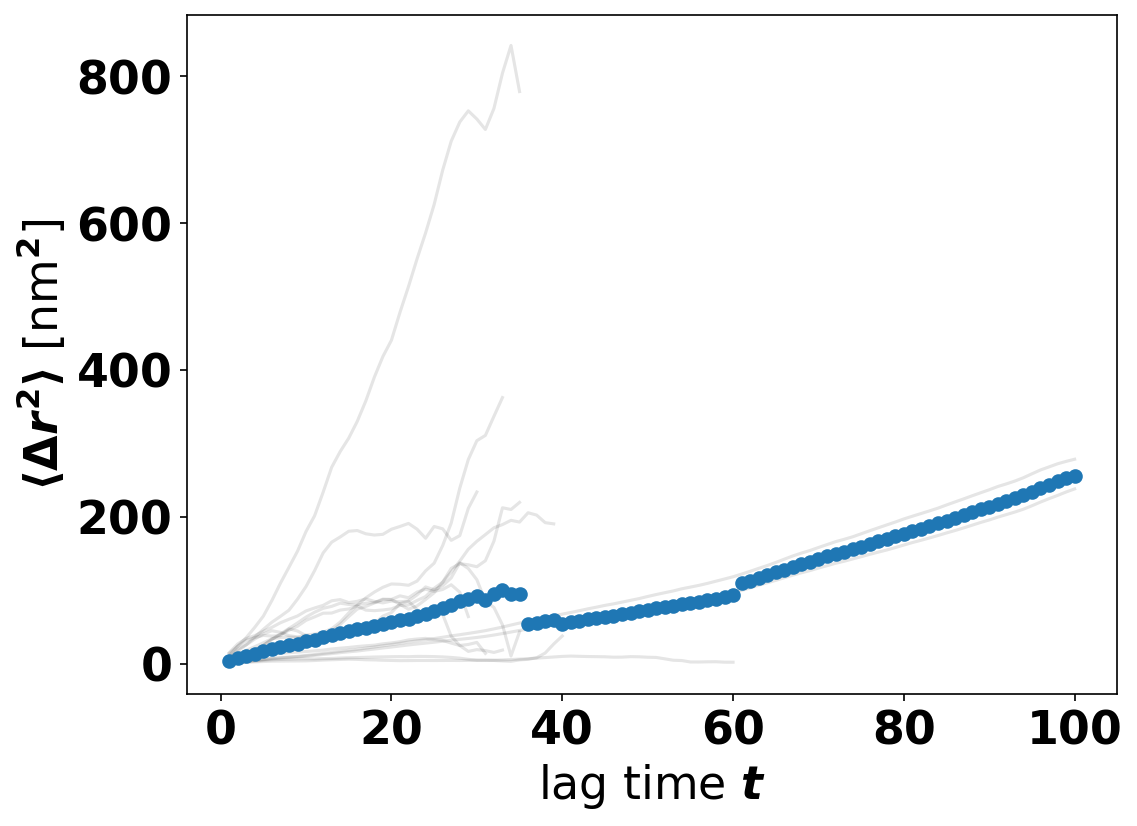

In [9]:
im = tp.imsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(im.index, im , 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [nm$^2$]',
       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')
em = tp.emsd(tm, frames.meters_per_pixel * 1e6, 1) * 1e6
ax.plot(em.index, em, 'o')

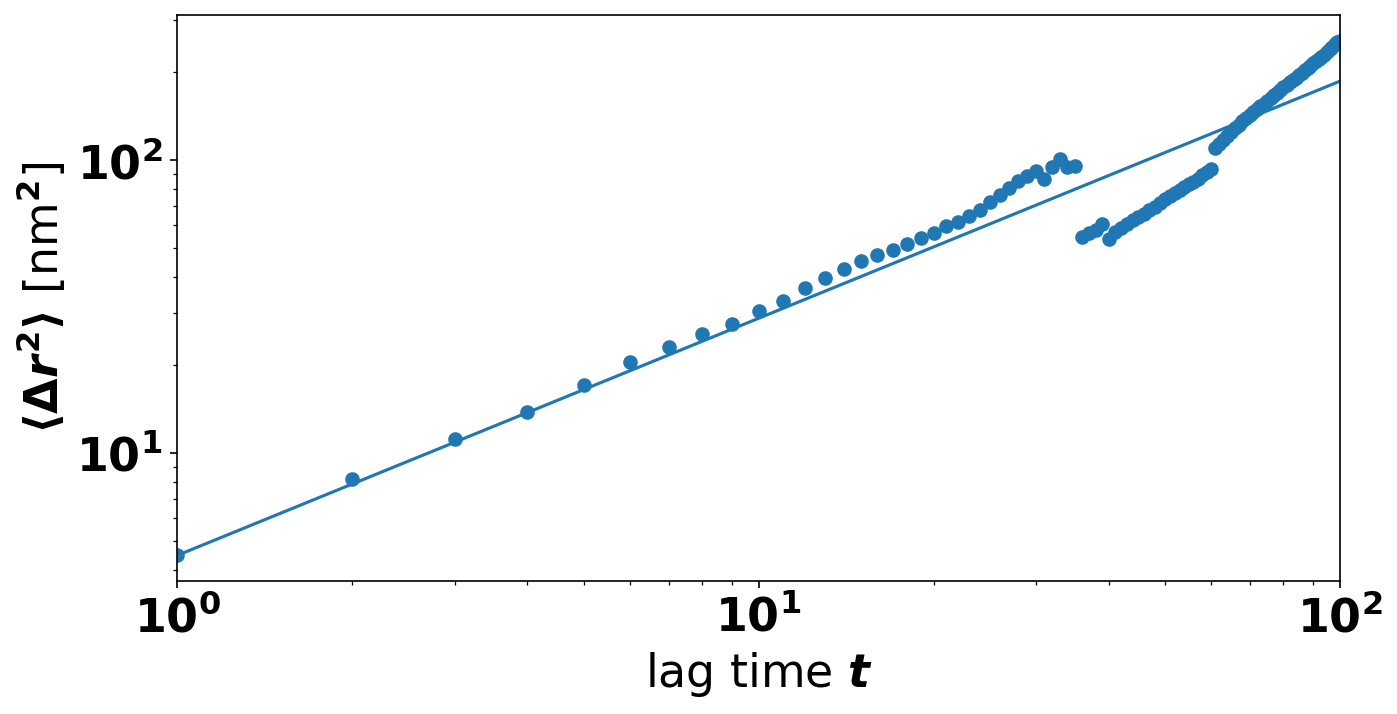

n         A
msd  0.809196  4.480129

In [10]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [nm$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)  # performs linear best fit in log space, plots]

In [11]:
em

lagt
1.0        4.497054
2.0        8.144820
3.0       11.143150
4.0       13.834795
5.0       17.091855
            ...    
96.0     239.647580
97.0     244.092640
98.0     248.442160
99.0     252.508837
100.0    256.165606
Name: msd, Length: 100, dtype: float64

In [12]:
t2.groupby('particle').apply(len)

particle
0      168
5      200
6       61
7       40
9       34
12      36
37      31
73      36
77      36
107     30
127     32
139     41
143     34
dtype: int64

# Deep Learning Classification

In [13]:
from tensorflow.keras.models import load_model
import keras_utils as ku

2021-12-06 18:27:12.539402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 18:27:12.539459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [27]:
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)

In [28]:
%autoreload 2
steps = 30
diff_class = {0 : 'fbm', 1 : 'brownian', 2 : 'ctrw'}
net_file = 'models/30_class_model.h5'
model = load_model(net_file)

def classify(df, steps=30, model=model):
    """
    Meant to be used with groupby
    """
    x = df.x.values
    dx = ku.generate_dx(x)
#     dx = dx[:steps-1]
    value, prediction = ku.classification_on_real(dx, steps=steps, model=model)
    df['class'] = diff_class[prediction]
    df['fbm_prob'], df['brownian_prob'], df['ctrw_prob'] = value[0], value[1], value[2]
    return df

t3 = t3.groupby('particle').apply(classify)

In [29]:
print(t3.groupby('particle')['fbm_prob'].unique().mean())
print(t3.groupby('particle')['brownian_prob'].unique().mean())
print(t3.groupby('particle')['ctrw_prob'].unique().mean())

[0.29599756]
[0.5030004]
[0.20100209]


In [30]:
t3.groupby('particle')['class'].unique().value_counts()

TypeError: unhashable type: 'numpy.ndarray'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'numpy.ndarray'


[brownian]    8
[fbm]         3
[ctrw]        2
Name: class, dtype: int64

## Alpha Estimation

In [34]:
%autoreload 2
steps = 30
fbm_alpha = net_file = load_model('models/{}-H-estimate.h5'.format(steps))
ctrw_alpha = net_file = load_model('models/model-alphaCTRW-estimate_{}.h5'.format(steps))

def alpha(df, steps=30):
    """
    Use with groupby('particle')
    """
    vals = df.iloc[0]
    fbm_p, brown_p, ctrw_p, prediction = vals['fbm_prob'], vals['brownian_prob'], vals['ctrw_prob'], vals['class']
    x = df.x.values
    dx = ku.generate_dx(x)
    return ku.alpha_on_real(dx, prediction, fbm_alpha, ctrw_alpha, steps=steps)
#     dx = dx[:steps-1]
#     fbm_a = ku.alpha_on_real(dx, 'fbm', fbm_alpha, ctrw_alpha, steps=steps)
#     ctrw_a = ku.alpha_on_real(dx, 'ctrw', fbm_alpha, ctrw_alpha, steps=steps)
#     brown_a = 1.0
#     return fbm_a * fbm_p + brown_p * brown_a + ctrw_a * ctrw_p

alphas = t3.groupby('particle').apply(alpha)

In [35]:
alphas

particle
0      1.000000
5      0.790139
6      1.000000
7      1.000000
9      1.000000
12     1.000000
37     1.000000
73     1.000000
77     1.000000
107    0.615490
127    0.730704
139    0.916888
143    0.700842
dtype: float64

In [37]:
np.nanmean(alphas)

0.9041586564137385